# <i class="fas fa-star"></i>&hairsp;T03: Volumetric Quantifications

This notebook demonstrates volume quantifications of neuronal arbors and their convex hulls.

```{hint}
By the end of this notebook, you will be able to:
- Generate a convex hull of axon terminals within a specific brain region
- Compare the volume of this convex hull to the volume of the brain region
- Apply Principal Component Analysis on point clouds of structures of interest
- Visualize the results of these operations using [Reconstruction Viewer](https://imagej.net/plugins/snt/reconstruction-viewer).

**Estimated Time**: 30-40 minutes
```

```{note}
Make sure to read these resources before running this notebook:
- [Install](../install.md) - Installation instructions
- [Quickstart](../quickstart.md) - Get started quickly
- [Overview](../overview.md) - Tour of pysnt's architecture
```

## Setup and Initialization

As in previous tutorials, we start by initializing pysnt:

In [2]:
import pysnt
pysnt.set_option('java.logging.level', 'Error') # Set logging level to 'Error' to reduce console output (see Overview for details)
pysnt.set_option('display.chart_format', 'svg') # SVG plots and histograms
pysnt.set_option('display.chart_dpi', 150) # Rendering resolution
pysnt.initialize()

Now we can import the modules that we will be needing in this notebook. In addition to the modules and classes used in [Tutorial 02](./02_hemisphere_analysis.ipynb), we will be using:

**API Reference:**
- {class}`pysnt.annotation.AllenCompartment`: Brain region annotations for the Allen CCF
- {class}`pysnt.viewer.Annotation3D`: Triangulated surface or point cloud annotations in Reconstruction Viewer
- {class}`pysnt.analysis.ConvexHull2D`: 2D convex hull computations
- {class}`pysnt.analysis.ConvexHull3D`: 3D convex hull computations

**Detailed Guides:**
- {doc}`AllenCompartment </pysnt/annotation/allencompartment_doc>`
- {doc}`Annotation3D </pysnt/viewer/annotation3d_doc>`
- {doc}`ConvexHull2D </pysnt/analysis/convexhull2d_doc>`
- {doc}`ConvexHull3D </pysnt/analysis/convexhull3d_doc>`

In [2]:
from pysnt import Tree
from pysnt.analysis import ConvexHull2D, ConvexHull3D, NodeStatistics, TreeStatistics
from pysnt.annotation import AllenUtils
from pysnt.viewer import Annotation3D, Viewer3D

## Load and Visualize Data
Dopaminergic neurons in the _substantia nigra_ are among the largest neurons in the mammalian brain, featuring massive axonal arbors that project exclusively to the dorsal striatum. Their death and degeneration lead to Parkinson's disease. These are some of the most fascinating cells in the mammalian brain, so let's study some exemplars in this tutorial.

> **Note:** In primates, the dorsal striatum is composed of the caudate and putamen, which form a single structure in mice. In this tutorial, we formalize 'dorsal striatum' as caudoputamen.

First, we will query the MouseLight database for this type of cell:

In [3]:
from pysnt.io import MouseLightQuerier

# Define the brain area of interest
snr = AllenUtils.getCompartment('Substantia nigra reticular part')
# Query for neurons with soma in snr
snr_neuron_ids = MouseLightQuerier.getIDs(snr)
print(snr_neuron_ids)

[AA1044, AA1447, AA1449]


Let's visualize these cells. We'll define three reusable functions, since this is a fairly common task:

1. `get_axon()`: Downloads axons from the MouseLight database using {class}`MouseLightLoader <pysnt.io.MouseLightLoader>`
2. `init_viewer()`: Assembles a {class}`Viewer3D <pysnt.viewer.Viewer3D>` (Reconstruction Viewer) with pre-loaded meshes
3. `display_orthoviews()`: Displays a montage of anatomical views of the 3D scene (used in [Tutorial 02](./02_hemisphere_analysis.ipynb))

In [4]:
def get_axon(id_string):
    """Fetches an axonal arbor from the MouseLight database using cell ID"""
    from pysnt.io import MouseLightLoader
    loader = MouseLightLoader(id_string)
    if not loader.isDatabaseAvailable():
        print("Could not connect to ML database", "Error")
        return None
    if not loader.idExists():
        print("Somehow the specified id was not found", "Error")
        return None
    # Extract the axon sub-tree
    return loader.getTree("axon")


def init_viewer(meshes):
    """Returns a Viewer3D instance pre-loaded with meshes"""
    from pysnt.viewer import Viewer3D
    viewer = Viewer3D()
    if meshes:
        viewer.add(meshes)
    viewer.loadRefBrain('ccf') # Load brain contour
    viewer.setEnableDarkMode(False) # light theme
    return viewer


def display_orthoviews(viewer):
    """Returns a Viewer3D instance pre-loaded with meshes"""
    from pysnt import display
    from pysnt.annotation import AllenUtils

    viewer.setEnableDarkMode(False) # light theme
    # Retrieve orthoview layout from pysnt.display()
    orthoviews = pysnt.display(viewer, orthoview=True, figsize=(20, 10)) # SNTObject dictionary
    fig = orthoviews['data'] # access the matplotlib figure

    # Replace the titles
    for axis in fig.get_axes():
        anatomical_plane = AllenUtils.getAnatomicalPlane(axis.get_title()) # Maps "xy" to "sagittal", "yz" to "coronal", ...
        if anatomical_plane:
            axis.set_title(anatomical_plane, fontsize=14, fontweight='regular')
        # Remove the box around each view
        for spine in axis.spines.values():
            spine.set_visible(False)

    # Force redraw
    fig.canvas.draw()
    return fig


Now we can display them:

```{tip}
If your operating system supports it, consider enabling interactive mode when initializing SNT (`pysnt.initialize(mode='interactive')`) to display the 3D scene in a native window using `viewer.show()`. 

**Important:** On some systems, code execution will pause until the viewer window is closed. For non-blocking visualization during analysis, use the default `pysnt.display(viewer)` option instead. See [Quirks and Limitations](../limitations.md#interactive-viewers) for details.
```

FALLBACK (log once): Fallback to SW vertex for line stipple
FALLBACK (log once): Fallback to SW vertex processing, m_disable_code: 2000
FALLBACK (log once): Fallback to SW vertex processing in drawCore, m_disable_code: 2000
Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the original ImageJ will have limited functionality.


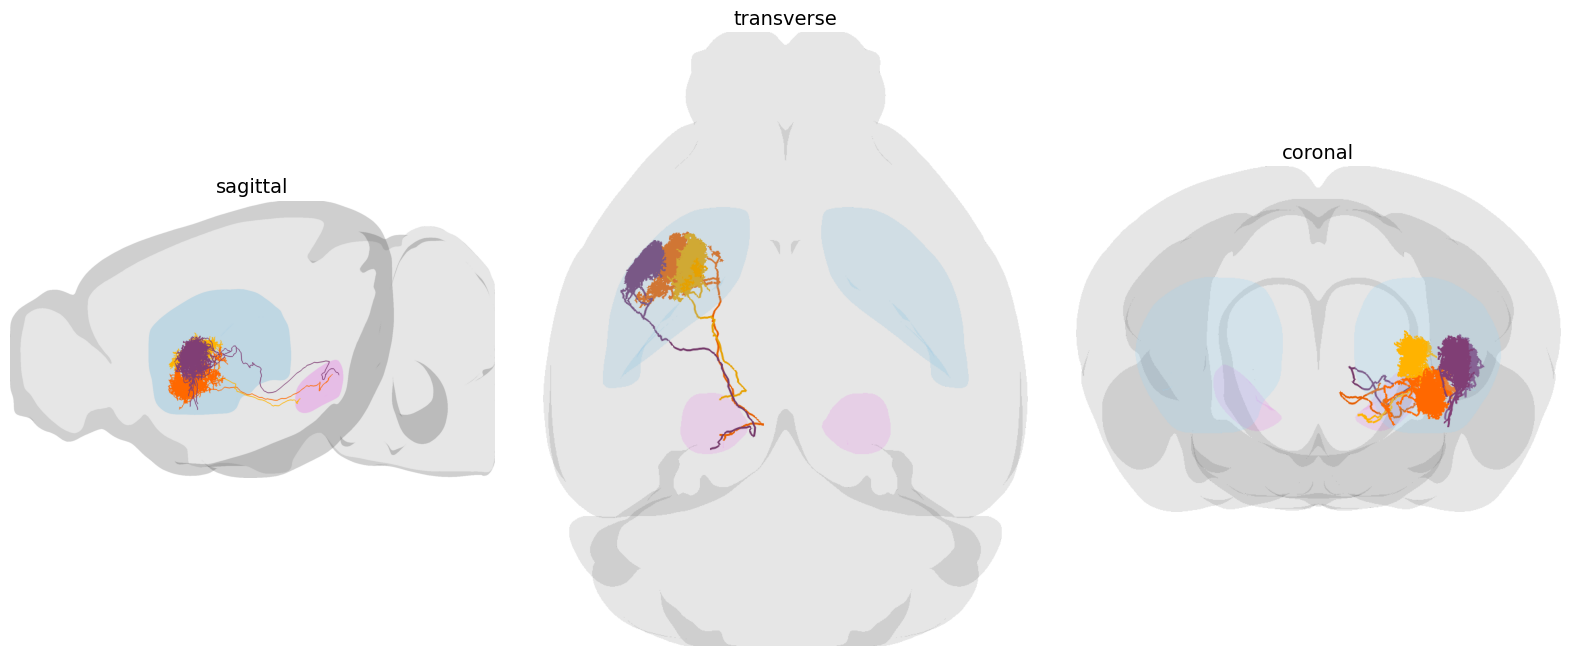

In [5]:
axons = []
for id in snr_neuron_ids:
    # To simplify the visualization, we'll assign
    # all axons to a common hemisphere (left)
    axon = get_axon(id)
    AllenUtils.assignToLeftHemisphere(axon)
    axons.append(axon)

# Add meshes for caudoputamen (CP) and substantia nigra ret. part (SNr)
compartment_labels = ["caudoputamen", 'Substantia nigra reticular part'] # CP, SNr
meshes = []
for clabel in compartment_labels:
    compartment = AllenUtils.getCompartment(clabel)
    meshes.append(compartment.getMesh())

viewer = init_viewer(meshes)
Tree.assignUniqueColors(axons) # Label each axon with a distinct color
viewer.add(axons)

fig = display_orthoviews(viewer)

A single unbranched, ipsilateral axon follows along the nigrostriatal tract—the nerve tract that connects the substantia nigra to the dorsal striatum—where it ramifies extensively into a compact, dense tuft composed of thousands of small branches.

Since these are ipsilateral neurons, we can zoom into the left hemi-half of the caudoputamen/SNr:

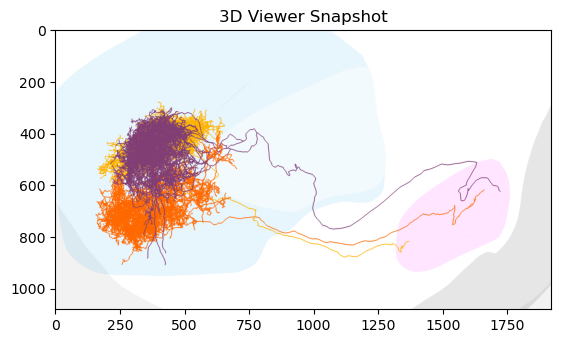

<java object 'ij.ImagePlus'>

In [ ]:
# The zoomTo() function accepts meshes, annotations, trees, paths, or
# string labels of rendered objects. It also accepts lists of such
# objects and bounding boxes:
bounds_cp = meshes[0].getBoundingBox('left') # CP left hemi-half
bounds_snr = meshes[1].getBoundingBox('left').scale([1.1, 1.1, 1.2]) # SNr left hemi-half, with 10-20% padding
viewer.zoomTo([bounds_cp, bounds_snr]) # Zoom to combined bounding box
viewer.setViewMode('anterior-posterior') # Cartesian XY axes
pysnt.display(viewer)

## Measure Cells
As in previous tutorials, we can use {class}`TreeStatistics <pysnt.analysis.TreeStatistics>` and {class}`MultiTreeStatistics <pysnt.analysis.MultiTreeStatistics>`:

In [7]:
for axon in axons:
    axon_stats = TreeStatistics(axon)
    print(f'{axon.getLabel()}:')
    print(f'  {len(axon_stats.getTips())} terminals')
    print(f'  {len(axon_stats.getBranches())} branches')
    print(f'  {axon_stats.getCableLength()} µm of cable length')

AA1044 (axon):
  2736 terminals
  5468 branches
  285979.15914921986 µm of cable length
AA1447 (axon):
  2378 terminals
  4754 branches
  340280.67768424784 µm of cable length
AA1449 (axon):
  2609 terminals
  5214 branches
  330027.0686187031 µm of cable length
  5214 branches
  330027.0686187031 µm of cable length


Or more conveniently:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 1050x350 with 3 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 3,
  'displayed_count': 3,
  'panel_layout': 'horizontal',
  'title': None},
 'error': None}

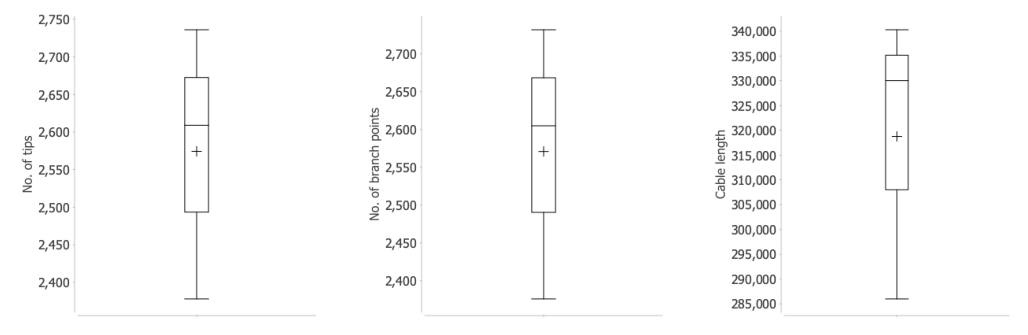

In [8]:
from pysnt.analysis import MultiTreeStatistics
m_stats = MultiTreeStatistics(axons)
metrics = ['No. of tips', 'No. of branch points', 'cable length']
plots = []
for metric in metrics:
    plots.append(m_stats.getBoxPlot(metric))
pysnt.display(plots, show_panel_titles=False, panel_layout='horizontal')

## Inspection of Terminals
We already know that the cell projects exclusively to the caudoputamen, but SNT is all about programmatic data inspection, so we can formally list all the locations of the axon terminals. For simplicity, let's focus on the first cell:

In [9]:
tree_axon = axons[0]  # Focus on the first axon
viewer.remove(axons[1]) # Remove all but the first axon from viewer
viewer.remove(axons[2]) # Remove all but the first axon from viewer

tips = TreeStatistics(tree_axon).getTips()
node_stats = NodeStatistics(tips)
node_map = node_stats.getAnnotatedNodes()
print('No. of terminals per brain area:')
for brain_area, node_list in node_map.items():
    print(f'  {brain_area.name()}: {len(node_list)} ({100 * len(node_list)/len(tips):.3f}%)')
#dist = node_stats.getAnnotatedHistogram() # Frequencies of brain annotations associated w/ tips
#pysnt.display(dist)

No. of terminals per brain area:
  nigrostriatal tract: 1 (0.037%)
  Caudoputamen: 2735 (99.963%)


We mentioned that the neuron projects exclusively to the caudoputamen, but 1 of the 2,736 endpoints is registered to the nigrostriatal tract. This is somewhat unexpected, as axons typically don't branch along the tract. This could be a registration error or an issue with metadata parsing. Let's examine this specific node:

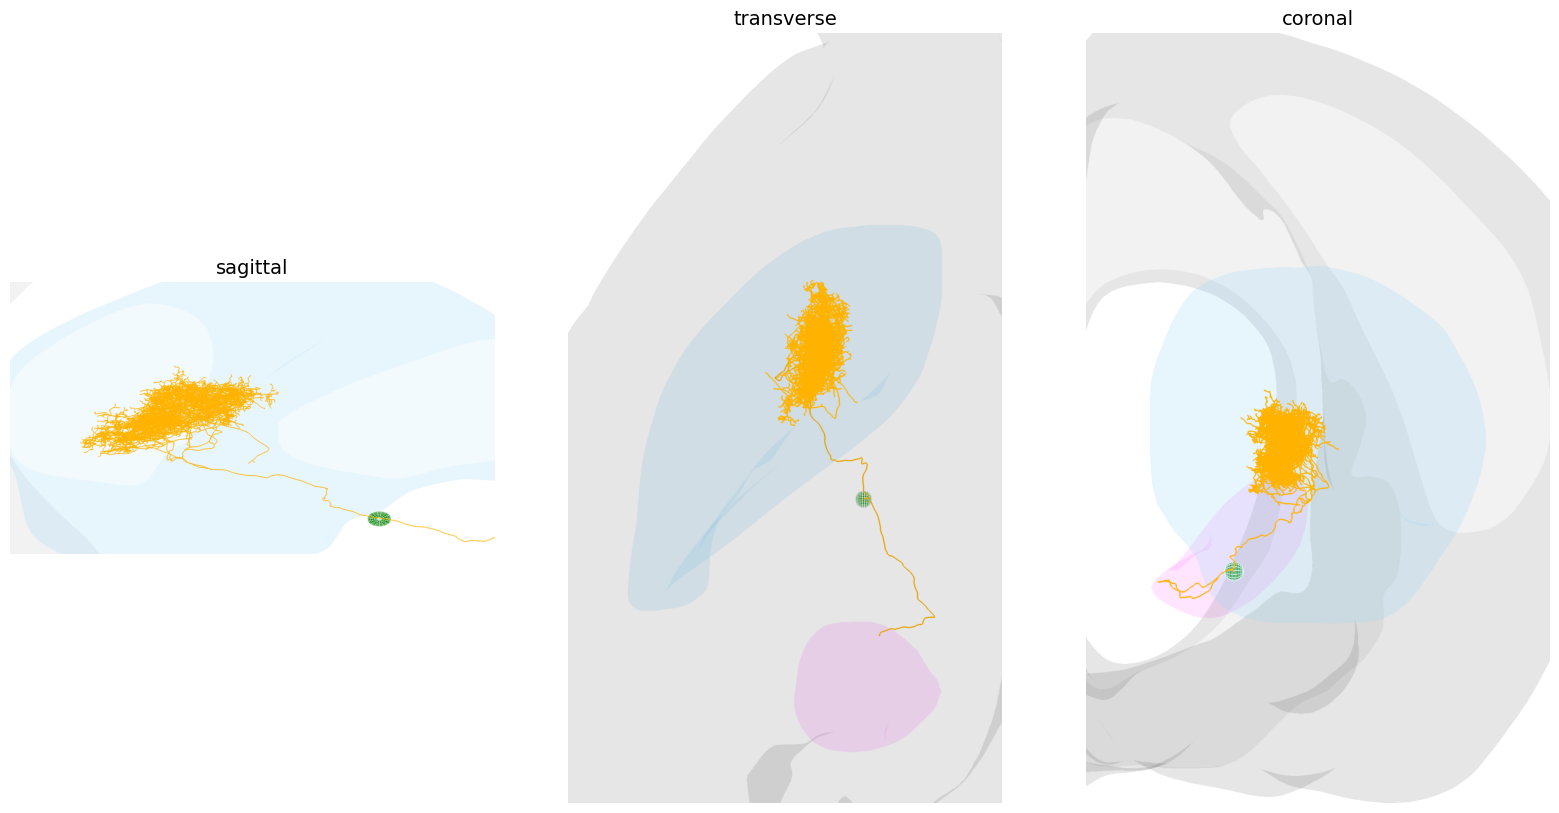

In [10]:
for brain_area, node_list in node_map.items():
    if brain_area.name() == 'nigrostriatal tract':
        outlier_node_annot = viewer.annotatePoints(node_list, "nodes in nst")
        outlier_node_annot.setColor('green')
        outlier_node_annot.setSize(90)
        viewer.zoomTo(bounds_cp)

fig = display_orthoviews(viewer)


This finding is particularly intriguing. The node's location is not at the boundary of the caudoputamen, which argues against a simple registration error. Another explanation is a reconstruction artifact. While MouseLight neurons are traced twice to ensure accurate reconstructions, the sheer scale and complexity of these arbors mean that annotation errors remain possible even under stringent quality control.

Let's explore it further: What kind of branch is associated with this terminal?

In [ ]:
# retrieve the outlier node(s) in the nigrostriatal tract. We know 
# there is just one, but we'll treat it as a list for generality
outlier_nodes = next(
    (nodes for area, nodes in node_map.items() 
     if area.name() == 'nigrostriatal tract'),
    None
)

# Let's create a NodeStatistics for the outlier node(s), but
# this time we'll make it aware of the full tree structure
# so we can access parent/child relationships
outlier_node_stats = NodeStatistics(outlier_nodes)
outlier_node_stats.assignBranches(tree_axon) # Make NodeStatistics aware of the full tree structure

# Now we could retrieve the frequency of branch types for these outlier nodes,
# but since we know there is just one, we can directly access it. The branch
# type is stored as the `onPath` property of the node.
outlier_node = next(iter(outlier_nodes))
outlier_branch = outlier_node.onPath

print('Outlier branch properties:')
print(f'  Length: {outlier_branch.getLength():.3f} µm')
print(f'  No. of nodes: {len(outlier_branch.getNodes())}')
print(f'  Contraction: {outlier_branch.getContraction():.3f}')

Outlier branch properties:
  Length: 59.640 µm
  No. of nodes: 4
  Contraction: 0.959


It is a very small and [straight](https://imagej.net/plugins/snt/metrics#branch-contraction) branch, with just 4 nodes and ~60 µm in length:

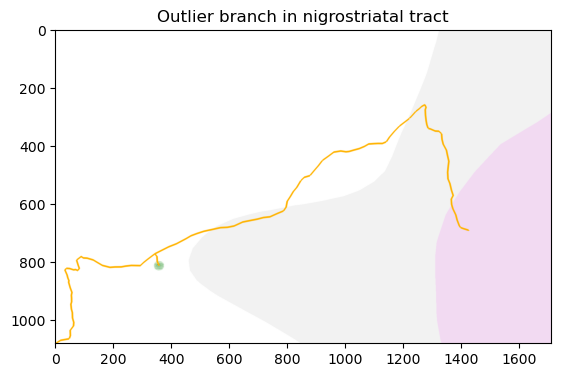

<java object 'ij.ImagePlus'>

In [12]:
viewer.setTreeThickness(6) # increase display thickness of skeletonized reconstruction
outlier_node_annot.setSize(25) # decrease contrast of outlier node

# Let's zoom into the outlier branch and a section of the main axon 
# The main axon is the first path of the axon tree
main_axonal_path = tree_axon.list()[0]
main_axonal_path_section = main_axonal_path.getSection(0, 100) # first 100 nodes of main axon
viewer.zoomTo([outlier_branch, main_axonal_path_section])
viewer.setViewMode('dorsal-ventral') # Cartesian XZ axes
pysnt.display(viewer, title='Outlier branch in nigrostriatal tract')

Let's check if the other cells also have similar branches:

In [13]:
for axon in axons:
    print(f'{axon.getLabel()}:')
    # retrieve terminal node locations
    node_stats = NodeStatistics(axon.getTips())
    node_stats_map = node_stats.getAnnotatedNodes()
    outlier_nodes = next(
        (nodes for area, nodes in node_stats_map.items() 
        if area.name() == 'nigrostriatal tract'),
        []
    )
    print(f'  No. of nodes in nigrostriatal tract: {len(outlier_nodes)}')

AA1044 (axon):
  No. of nodes in nigrostriatal tract: 1
AA1447 (axon):
  No. of nodes in nigrostriatal tract: 0
AA1449 (axon):
  No. of nodes in nigrostriatal tract: 0


They don't. So far we have established two key points: 1) the terminal is valid and not a parsing artifact, and 2) it is associated with a small branch in the nigrostriatal tract. The next logical step would be to visit [HortaCloud](https://hortacloud.janelia.org/) and examine the raw imagery at this branch location. However, that visualization process falls outside the scope of this tutorial and will be covered in a future notebook.

Let's continue analyzing the CP terminals, ignoring this single nigrostriatal tract terminal for now. We can programmatically find the compartment containing the maximum number of axon terminals:

In [14]:
# Get the compartment containing the maximum number of axon terminals
max_compartment = max(node_map, key= lambda x: len(node_map[x]))
# Get the associated list of terminals
max_compartment_tips = node_map[max_compartment]
print(f'Compartment with maximum terminals: {max_compartment.name()} ({len(max_compartment_tips)} terminals)')

Compartment with maximum terminals: Caudoputamen (2735 terminals)


## Computing Convex Hulls

We compute the convex hull of the point cloud formed by the CP terminals, either in 2D:

[SNTUtils] Retrieving org.scijava.Context...

[INFO] [SNT] 116 scijava services loaded
2D Convex hull area: 1184262.16µm²
2D Convex hull perimeter: 4177.58µm


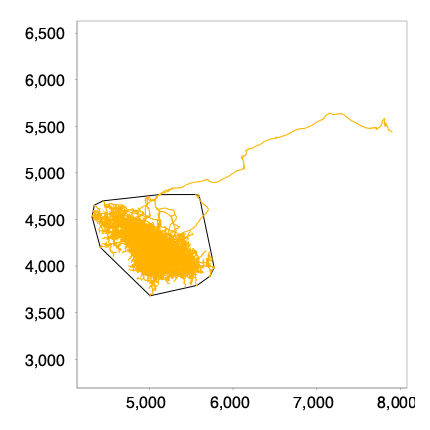

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [15]:
from pysnt.analysis import ConvexHull2D

# If we compute a 2D convex hull over a 3D Tree, z coordinates are ignored
axon_hull_2D = ConvexHull2D(max_compartment_tips)
print(f'2D Convex hull area: {axon_hull_2D.size():.2f}µm²') # size() -> area in 2D; volume in 3D
print(f'2D Convex hull perimeter: {axon_hull_2D.boundarySize():.2f}µm') # boundarySize() -> perimeter in 2D; area in 3D

# Now visualize the 2D convex hull in the 2D viewer.
# The 2D viewer is not optimized for large reconstructions, so this can be rather slow!!
from pysnt.viewer import Viewer2D
viewer2d = Viewer2D()
viewer2d.add(tree_axon)
viewer2d.add(axon_hull_2D.getPolygon())
pysnt.display(viewer2d)

Or compute it in 3D:

In [16]:
from pysnt.analysis import ConvexHull3D

axon_hull_3D = ConvexHull3D(max_compartment_tips)
print(f'3D Convex hull volume: {axon_hull_3D.size():.2f}µm³') # size() -> area in 2D; volume in 3D
print(f'3D Convex hull area: {axon_hull_3D.boundarySize():.2f}µm²') # boundarySize() -> perimeter in 2D; area in 3D

3D Convex hull volume: 584596681.45µm³
3D Convex hull area: 3868120.07µm²


To visualize the 3D convex hull:

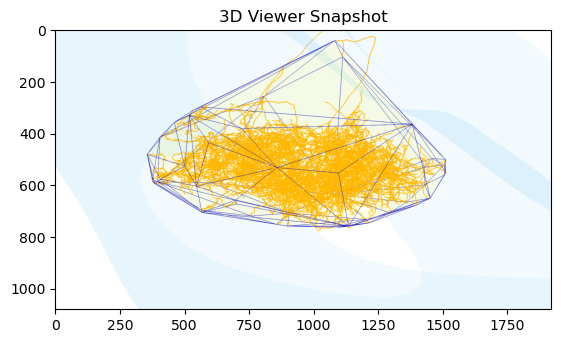

<java object 'ij.ImagePlus'>

In [17]:
max_compartment_mesh = max_compartment.getMesh()
viewer = init_viewer(max_compartment_mesh) # start a new scene
viewer.add(tree_axon)

# Construct a drawable for Viewer3D from the Convex Hull Mesh
hull_annotation = Annotation3D(
    axon_hull_3D.getMesh(), 
    f"Convex hull of axon terminals within ipsilateral {max_compartment.name()}"
)
hull_annotation.setColor("yellow", 95) # transparency (%)
viewer.add(hull_annotation)
viewer.zoomTo(hull_annotation)
pysnt.display(viewer)

Retrieval of mesh volumes is simplified because OBJMesh features pre-computed volumes (via surface integrals)¹. 

¹ NB: However, certain meshes (e.g., third ventricle) are not watertight, which precludes a direct volume calculation.

In [18]:
# Now compare the volumes of the 3D convex hull and the compartment mesh
# Since this compartment mesh is composed of both hemi-halves, we can approximate
# the volume of one hemi-half by dividing the total mesh volume by 2
print("% of volume occupied by the convex hull of "
      "the axon terminals with respect to the ipsilateral {} {:0.2f}%"
      .format(max_compartment, (axon_hull_3D.size() / (0.5 * max_compartment_mesh.getVolume())) * 100)
)

% of volume occupied by the convex hull of the axon terminals with respect to the ipsilateral CP: Caudoputamen  (672) 4.51%


## Geometric Computations

Let's analyze the overall orientation and shape characteristics of the point cloud defined by the axon terminals. By computing the principal axes via PCA (Principal Component Analysis), we can determine the directions of maximum variance in the data, quantify the degree of anisotropy, and identify any preferred orientations or dimensional constraints (e.g., elongation along one axis or confinement to a plane).

We can use SNT's built-in {class}`pysnt.analysis.PCAnalyzer` and define a reusable function:

In [19]:
def get_pca_axes(list_of_nodes):
    """Returns PCA axes from a list of nodes (SNTPoint objects)"""
    from pysnt.analysis import PCAnalyzer

    # Retrieve the principal axes from the PCA analysis
    pca_axes = PCAnalyzer.getPrincipalAxes(list_of_nodes)
    for i, axis in enumerate(pca_axes):
        print(f'Principal Axis {i}:')
        print(f'  Eigenvalue: {axis.getEigenvalue():.2f}')
        variances_percent = PCAnalyzer.getVariancePercentages(pca_axes)
        print(f'  Variance: {variances_percent[i]:.2f}%')
        print(f'  Direction (X,Y,Z): {axis.getX():.3f}, {axis.getY():.3f}, {axis.getZ():.3f}')
    return pca_axes

print('PCA axes for axon terminals:')
pca_axes_tips = get_pca_axes(max_compartment_tips)

PCA axes for axon terminals:
Principal Axis 0:
  Eigenvalue: 101655.38
  Variance: 77.35%
  Direction (X,Y,Z): 0.864, -0.475, -0.167
Principal Axis 1:
  Eigenvalue: 17865.09
  Variance: 13.59%
  Direction (X,Y,Z): -0.386, -0.837, 0.387
Principal Axis 2:
  Eigenvalue: 11904.63
  Variance: 9.06%
  Direction (X,Y,Z): -0.324, -0.270, -0.907


The endpoints exhibit strongly anisotropic spatial organization. The first principal component captures ~77% of the spatial variance, indicating the arbor is highly elongated along a primary axis oriented in the direction (−0.864, 0.475, 0.167).

The second principal component accounts for ~14% of variance with direction (−0.386, −0.837, 0.387), representing moderate spread perpendicular to the primary axis.

The third component explains only ~9% of variance along direction (−0.324, −0.270, −0.907), showing limited spread in a predominantly negative Z direction.

The high variance ratio (77%:14%:9%) supports what we have already determined: this arbor has a strongly directional morphology, with branches distributed primarily along a single preferred axis. Let's render these orientations using a dedicated function:

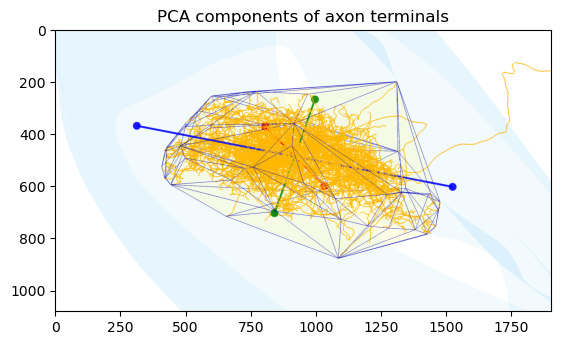

<java object 'ij.ImagePlus'>

In [20]:
def annotate_pca_axes(viewer, pca_axes, list_of_nodes, scale=3, thickness=30, label='component'):
    """Renders PCA axes in the given Viewer3D instance. Directions are centered in the centroid of provided nodes."""
    import numpy as np
    from pysnt.util import SNTPoint

    pca_colors = ['blue', 'red', 'green'] # PC1, PC2, PC3
    for i, axis in enumerate(pca_axes):

        # Define the start and end points of the PCA axis using numpy
        node_coords = [[t.getX(), t.getY(), t.getZ()] for t in list_of_nodes]
        centroid = np.mean(node_coords, axis=0)
        direction = np.array([axis.getX(), axis.getY(), axis.getZ()])
        amplitude = np.sqrt(axis.getEigenvalue()) * scale  # scale for visualization
        start_point = centroid - amplitude * direction
        end_point = centroid + amplitude * direction

        # Define the start and end points of the axis line segment as SNTPoints
        start = SNTPoint.of(start_point[0], start_point[1], start_point[2])
        end = SNTPoint.of(end_point[0], end_point[1], end_point[2])

        # Create vector annotations for each component
        annot = viewer.annotateLine([start, end], "{} axis{}".format(label, i))
        annot.setColor(pca_colors[i], 10) # hue, transparency (%)
        annot.setSize(thickness)

annotate_pca_axes(viewer, pca_axes_tips, max_compartment_tips, label='PCA tips')
viewer.setViewMode('dorsal-ventral') # Cartesian XZ axes
viewer.zoomTo(hull_annotation)
pysnt.display(viewer, title='PCA components of axon terminals')

How do these axes compare to those of the target CP? Let's compute the PCA for the ipsilateral CP hemisphere:

In [21]:
# Construct PCA vectors using the eigenvectors
cp_vertices = max_compartment_mesh.getVertices('left')
print('PCA axes for axon CP ipsilateral half:')
pca_axes_cp = get_pca_axes(cp_vertices)

print('\nRelationship between axes:')
for i, axis in enumerate(pca_axes_cp):
    angle_with_tips_pca = axis.getAngleWith(pca_axes_tips[i].getX(), pca_axes_tips[i].getY(), pca_axes_tips[i].getZ())
    print(f'  Acute angle between PC{i} tips - PC{i} CP half: {angle_with_tips_pca:.3f}°')

PCA axes for axon CP ipsilateral half:
Principal Axis 0:
  Eigenvalue: 1774870.83
  Variance: 59.93%
  Direction (X,Y,Z): 0.788, -0.165, -0.593
Principal Axis 1:
  Eigenvalue: 952648.61
  Variance: 32.17%
  Direction (X,Y,Z): -0.003, 0.962, -0.272
Principal Axis 2:
  Eigenvalue: 233943.43
  Variance: 7.90%
  Direction (X,Y,Z): -0.616, -0.216, -0.758

Relationship between axes:
  Acute angle between PC0 tips - PC0 CP half: 30.881°
  Acute angle between PC1 tips - PC1 CP half: 24.494°
  Acute angle between PC2 tips - PC2 CP half: 19.130°


The terminals exhibit orientations that match the geometric structure of their target brain region. All three principal axes of the terminal distribution are well-aligned with the corresponding axes of the ipsilateral caudoputamen, with angular differences of 30.9°, 24.5°, and 19.1°.

Let's overlay the last PCA axes on the scene:

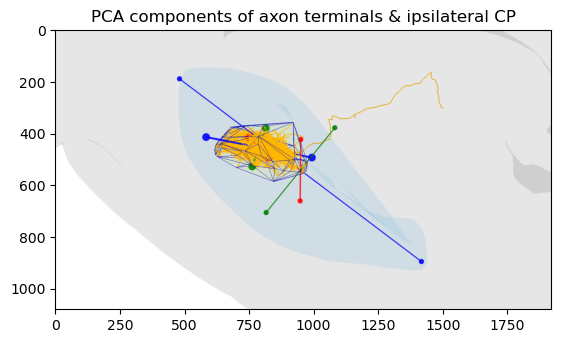

<java object 'ij.ImagePlus'>

In [22]:
annotate_pca_axes(viewer, pca_axes_cp, cp_vertices, scale=1.8, thickness=20, label='CP-ipsi')
viewer.zoomTo(max_compartment_mesh.getBoundingBox('left'))
pysnt.display(viewer, title='PCA components of axon terminals & ipsilateral CP')

This suggests the arbor conforms closely to the three-dimensional constraints of the caudoputamen, which argues against a random projection pattern and instead suggests a geometrically constrained and potentially functionally optimized distribution of terminals within the CP.

## Filtering Operations

You may have noticed that a handful of endpoints were rather distant from the remaining endpoints. We can use a statistical approach based on the nearest neighbor distance (NND) distribution to identify and eliminate outliers in the point cloud of axonal tips:

- Compute all NNDs for the point cloud
- Analyze the NND distribution (mean and standard deviation)
- Define outlier thresholds based on the distribution (e.g., points with NND > mean + 2×SD)

NodeStatistics allows for this directly:

In [23]:
tips_stats = NodeStatistics(max_compartment_tips)

dstats = tips_stats.getDescriptiveStatistics('nearest neighbor distance')
upper_bound = dstats.getMean() + 2 * dstats.getStandardDeviation()
print(f'Filtering terminals with nearest neighbor distance > {upper_bound:.2f}µm')

Filtering terminals with nearest neighbor distance > 57.12µm


Let's visualize the cutoff value on the histogram:

[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(23.6267, 16.7445)] = -11595.6377
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.79 x Gaussian Distribution(22.9993, 14.2681) + 0.21 x Gaussian Distribution(25.9354, 23.5736)] = -11187.2895
[Run$_main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(3)[0.76 x Gaussian Distribution(22.6161, 12.9353) + 0.22 x Gaussian Distribution(25.4731, 19.0529) + 0.02 x Gaussian Distribution(38.0998, 52.0712)] = -10865.3867


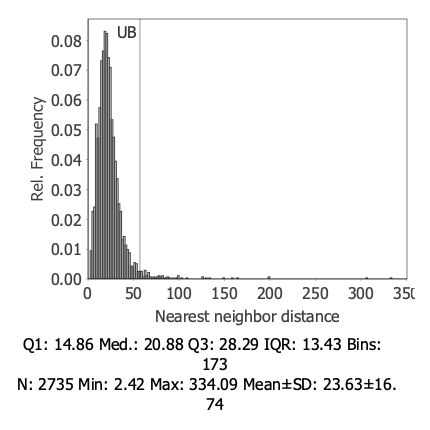

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Hist. Nearest neighbor distance',
  'containsValidData': True,
  'isLegendVisible': False},
 'error': None}

In [24]:
hist = tips_stats.getHistogram('nearest neighbor distance')
hist.annotateXline(upper_bound, 'UB')
pysnt.display(hist)

Now that we have defined the cutoff value, we can use the filter function of {class}`pysnt.analysis.NodeStatistics` to eliminate locations beyond the cutoff and assemble a new convex hull from the remaining 'core' terminals:

No. of terminals after filtering: 2667 (out of 2735)


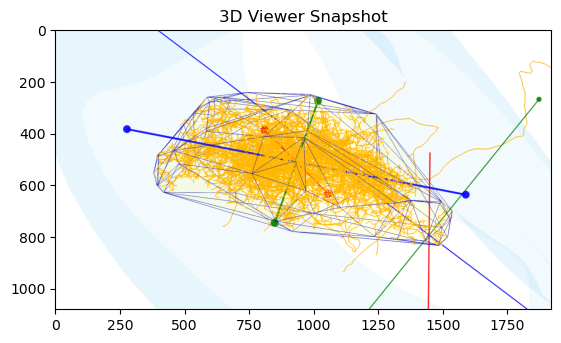

<java object 'ij.ImagePlus'>

In [25]:
filtered_tips = tips_stats.filter('nearest neighbor distance', 0, upper_bound)
print(f'No. of terminals after filtering: {len(filtered_tips)} (out of {len(max_compartment_tips)})')
tighter_axon_hull_3D = ConvexHull3D(filtered_tips)
filtered_hull_annotation = Annotation3D(tighter_axon_hull_3D.getMesh(), 'filtered convex hull')
filtered_hull_annotation.setColor("yellow", 95) # hue, transparency (%)


viewer.remove(hull_annotation) # remove previous hull
viewer.add(filtered_hull_annotation)
viewer.zoomTo(filtered_hull_annotation)
pysnt.display(viewer)

The new convex hull is much more representative of the overall arbor and includes ~97% of its terminals.

## Follow-up Questions

1. Can you extend the analysis to the remaining cells?

2. How would the convex hull and PCA results change if you included all three neurons?


## Data Sources and References

Data used in this notebook:

 - Cells [AA1044](https://doi.org/10.25378/janelia.7822307), [AA1447](https://doi.org/10.25378/janelia.27655194), [AA1449](https://doi.org/10.25378/janelia.27655200) of the [MouseLight database](https://ml-neuronbrowser.janelia.org/), under a Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)).

 - The Allen Mouse Brain Common Coordinate Framework (CCFv3) is openly accessible at https://atlas.brain-map.org/ under the Allen Institute’s [Terms of Use](https://alleninstitute.org/terms-of-use/)

 See [SNT citation](https://imagej.net/plugins/snt/faq#how-do-i-cite-snt) for details on how to properly cite SNT.